# Evaluation of Convnext U-Net and Cbam U-Net architectures

In this notebook, we will evaluate the performance of ConvNeXt U-Net and CBAM U-Net with regards to the segmentation of dermatoscopic images of skin lesions. The images are part of the ISIC2018 Dataset. Both training and prediction were done via the medical image segmentation framework MIScnn. We will compare the results of ConvNeXt U-Net and CBAM U-Net to the predictions made with a standard U-Net architecture with regards to the following metrics:

+ Dice/f1-score
+ Sensitivity
+ Specificity
   
The methods for calculating the metrics are provided by the module miseval.

This notebook is part of my bachelor thesis at the chair of IT-infrastrucutres for translational medical research at the university of augsburg.

MIScnn: https://github.com/frankkramer-lab/MIScnn

miseval: https://github.com/frankkramer-lab/miseval

ISIC2018: https://challenge.isic-archive.com/landing/2018/

In order to directly access a chapter, please refer to the table of contents below.

---

**Table of contents**

1. [Sampling predictions](#sampling)
2. [Inspecting inaccurate predictions](#artefacts)
3. [Evaluation](#eval)

---

*Note*: Since a large amount of images can lead to lag and stuttering, they are by default referenced by a markdown hyperlink, which will open the image in a seperate tab if you are using an IDE such as vscode to access the repository. The code can alternatively be changed to directly display the image in the notebook. To do this, change the lines for displaying the images by providing the Pillow Image object instead of the path to the image. In other words, simply replace 

```python
display_switch("path/to/image", title)
```

with  

```python
display_switch(image, title)
```

where 'image' is a Pillow Image object and 'path/to/image' is the path to the image as a string. For further information, see the docstring of 'display_switch'.


## 1. Sampling predictions <a id="sampling"></a>

First, we will visualize some of the results of our work. Each image in the dataset comes with a binary segmentation mask annotated by experts, which represents the ground truth we will compare our predicted segmentation masks against.

We chose the following sample images to display the ground truth mask and the segmentation mask to visually compare them:

1. ISIC_0014787
2. ISIC_0015967
3. ISIC_0013577
4. ISIC_0015245
5. ISIC_0016037

In [4]:
# Import some libraries
import numpy as np
from IPython.core.display import Markdown, display_markdown
from PIL import Image, ImageDraw, ImageFont
from miscnn.data_loading.interfaces import Image_interface
from miscnn.data_loading.data_io import Data_IO
from matplotlib import pyplot as plt
from typing import Union

In [5]:
# ----------------------------   Paths   ------------------------------------ # 
# Change these paths to where the corresponding data is stored on your system #
# --------------------------------------------------------------------------- #
# Path to the test subset of the ISIC2018 dataset
data_path = "isic_seg/test/data/"
# Path to predictions (U-Net)
standard_predictions_path = "standard/isic/predictions/"
# Path to predictions (Cbam U-Net)
cbam_predictions_path = "cbam/isic/predictions/"
# Path to predictions (ConvNeXt U-Net)
convnext_predictions_path = "convnext/isic/predictions/"


# Configure Data_IO objects used to load segmentation masks
interface = Image_interface(classes=2, img_type="rgb", img_format="png")

# --- ISIC predictions interfaces

data_io_standard = Data_IO(interface, data_path, delete_batchDir=True, output_path=standard_predictions_path)
data_io_cbam = Data_IO(interface, data_path, delete_batchDir=True, output_path=cbam_predictions_path)
data_io_convnext = Data_IO(interface, data_path, delete_batchDir=True, output_path=convnext_predictions_path)


# --- Helper methods and variables ---

def concat_images_2x2(im1: Image.Image, im2: Image.Image, im3: Image.Image, im4: Image.Image) -> Image.Image:
    """
    Assembles 4 images into a 2x2 grid of the following form:\n
    im1 im2\n
    im3 im4\n

    Args:
        im1 (Image): image to display in upper left corner
        im2 (Image): image to display in upper right corner
        im3 (Image): image to display in lower left corner
        im4 (Image): image to display in lower right corner
    
    Returns:
        dst (Image): 2x2 grid image
    """
    dst = Image.new('RGB', (2*im1.width , 2*im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    dst.paste(im3, (0, im1.height))
    dst.paste(im4, (im1.width, im1.height))
    return dst


def display_switch(img: Union[str, Image.Image], title: str = "text") -> None:
    """Displays an image directly or creates a markdown reference opening the image in a new tab
    
    Rendering image directly:
    >>> sample = Data_IO.sample_loader(index)
    >>> img = Image.fromarray(sample.img_data)
    >>> display_switch(img)
    
    Displaying a markdown reference
    >>> sample = Data_IO.sample_loader(index)
    >>> img = Image.fromarray(sample.img_data)
    >>> img.save('Images/image.png')
    >>> display_switch('Images/image.png', 'link text')

    Args:
        img (Image | str): Image to display. Can be a Pillow image or the path to a image
        title (str, optional): Text of the reference if linked in markdown. Defaults to "".
    """
    if isinstance(img, Image.Image):
        print(title)
        display(img)
    else:
        display_markdown(Markdown(f"[{title}]({img})"))

font = ImageFont.truetype("Montserrat.ttf", size=160)

# --- Generate images ---

# Sample indices and complete indices list
sample_indices = [248, 503, 112, 398, 567]
indices_list = data_io_standard.get_indiceslist()

for index in sample_indices:

    # Load sample and image and mask data
    sample = data_io_standard.sample_loader(indices_list[index], load_pred=True, load_seg=True)
    img = sample.img_data
    seg_data = sample.seg_data
    
    # Create image of the ground truth mask
    seg = Image.fromarray(np.reshape(seg_data, seg_data.shape[:-1]))
    seg = seg.convert("RGBA")
    seg.putalpha(128)

    # Load prediction data
    pred_data_standard = sample.pred_data
    pred_data_cbam = data_io_cbam.sample_loader(indices_list[index], load_pred=True).pred_data
    pred_data_convnext = data_io_convnext.sample_loader(indices_list[index], load_pred=True).pred_data

    # Create standard unet prediction image
    pred_standard = Image.fromarray(np.reshape(pred_data_standard, pred_data_standard.shape[:-1]))
    pred_standard = pred_standard.convert("RGBA")
    pred_standard.putalpha(255)
    pred_standard.alpha_composite(seg)
    # Draw header
    draw = ImageDraw.Draw(pred_standard)
    draw.text((100, 100),"Standard U-Net", font=font, stroke_width=10)

    # Create cbam unet prediction image
    pred_cbam = Image.fromarray(np.reshape(pred_data_cbam, pred_data_cbam.shape[:-1]))
    pred_cbam = pred_cbam.convert("RGBA")
    pred_cbam.putalpha(255)
    pred_cbam.alpha_composite(seg)
    # Draw header
    draw = ImageDraw.Draw(pred_cbam)
    draw.text((100, 100),"CBAM U-Net", font=font, stroke_width=10)

    # Create convnext prediction imahe
    pred_convnext = Image.fromarray(np.reshape(pred_data_convnext, pred_data_convnext.shape[:-1]))
    pred_convnext = pred_convnext.convert("RGBA")
    pred_convnext.putalpha(255)
    pred_convnext.alpha_composite(seg)
    # Draw header
    draw = ImageDraw.Draw(pred_convnext)
    draw.text((100, 100),"ConvNeXt U-Net", font=font, stroke_width=10)

    # Save original image
    img = Image.fromarray(img)
    img.save(f"Images/{indices_list[index]}_image.png")

    # Draw header (ground truth mask)
    draw = ImageDraw.Draw(seg)
    draw.text((100, 100),"Ground Truth", font=font, stroke_width=10)

    # Concatenate images
    dst = concat_images_2x2(seg, pred_standard, pred_cbam, pred_convnext)
    dst.save(f"Images/{indices_list[index]}_masks.png")
    
    print(indices_list[index])
    
    display_switch(f"Images/{indices_list[index]}_image.png", "Original Image")
    #display_switch(img, "Original Image")
    display_switch(f"Images/{indices_list[index]}_masks.png", "Masks")
    #display_switch(dst, "Original Image")


ISIC_0014787


[Original Image](Images/ISIC_0014787_image.png)

[Masks](Images/ISIC_0014787_masks.png)

ISIC_0015967


[Original Image](Images/ISIC_0015967_image.png)

[Masks](Images/ISIC_0015967_masks.png)

ISIC_0013577


[Original Image](Images/ISIC_0013577_image.png)

[Masks](Images/ISIC_0013577_masks.png)

ISIC_0015245


[Original Image](Images/ISIC_0015245_image.png)

[Masks](Images/ISIC_0015245_masks.png)

ISIC_0016037


[Original Image](Images/ISIC_0016037_image.png)

[Masks](Images/ISIC_0016037_masks.png)

# 2. Inspecting inaccurate predictions <a id="artefacts"></a>

We will continue by looking at images where the predictions contained a high number of cases in which the neural networks falsely classified areas or pixels as belonging to the foreground, represented by the number of false positive pixels in the predictions masks (0 in ground truth, 1 in prediction). We will display these images and compare the number of false positives between the different models, giving us a better understanding of the architectures performances with regards to cases, in which the generated prediction deviated from the ground truth.

In [6]:
def count_false_positives(truth: np.ndarray, pred: np.ndarray, c=1) -> int:
    """Counts the number of false positives given the ground truth and a prediction.

    Args:
        truth (numpy.ndarray): ground truth mask as a numpy array
        pred (numpy.ndarray): prediction as a numpy array
        c (int, optional): class to count the number of false positives for. Defaults to 1.

    Returns:
        int: number of false positives
    """
    gt = np.equal(truth, c)
    not_gt = np.logical_not(gt)
    pd = np.equal(pred, c)
    
    return int(np.logical_and(pd, not_gt).sum())

io_dict = {
    "cbam": data_io_cbam,
    "convnext": data_io_convnext,
    "standard": data_io_standard    
}

false_positives_dict = {}

# Iterate over images
for index in indices_list:
    
    false_positives_dict[index] = {}
    
    for model, io in io_dict.items():
        # Load masks
        seg = io.sample_loader(index, load_seg=True).seg_data
        pred = io.sample_loader(index, load_pred=True).pred_data
        
        # Count false positives for every image and model
        false_positives_dict[index][model] = count_false_positives(seg, pred, c=255)

# Sort images by  max number of false positives across the models
sorted_fp = sorted(
    false_positives_dict.items(),
    key = lambda x: max([x[1]["cbam"], x[1]["convnext"], x[1]["standard"]]),
    reverse=True
)

In [7]:
sample_indices = range(20)

for index in sample_indices:

    # Load sample and image and mask data
    sample = data_io_standard.sample_loader(sorted_fp[index][0], load_pred=True, load_seg=True)
    img = sample.img_data
    seg_data = sample.seg_data
    
    # Create image of the ground truth mask
    seg = Image.fromarray(np.reshape(seg_data, seg_data.shape[:-1]))
    seg = seg.convert("RGBA")
    seg.putalpha(128)

    # Load prediction data
    pred_data_standard = sample.pred_data
    pred_data_cbam = data_io_cbam.sample_loader(sorted_fp[index][0], load_pred=True).pred_data
    pred_data_convnext = data_io_convnext.sample_loader(sorted_fp[index][0], load_pred=True).pred_data

    # Create standard unet prediction image
    pred_standard = Image.fromarray(np.reshape(pred_data_standard, pred_data_standard.shape[:-1]))
    pred_standard = pred_standard.convert("RGBA")
    pred_standard.putalpha(255)
    pred_standard.alpha_composite(seg)
    # Draw header
    draw = ImageDraw.Draw(pred_standard)
    draw.text((100, 100),"Standard U-Net", font=font, stroke_width=10)

    # Create cbam unet prediction image
    pred_cbam = Image.fromarray(np.reshape(pred_data_cbam, pred_data_cbam.shape[:-1]))
    pred_cbam = pred_cbam.convert("RGBA")
    pred_cbam.putalpha(255)
    pred_cbam.alpha_composite(seg)
    # Draw header
    draw = ImageDraw.Draw(pred_cbam)
    draw.text((100, 100),"CBAM U-Net", font=font, stroke_width=10)

    # Create convnext prediction imahe
    pred_convnext = Image.fromarray(np.reshape(pred_data_convnext, pred_data_convnext.shape[:-1]))
    pred_convnext = pred_convnext.convert("RGBA")
    pred_convnext.putalpha(255)
    pred_convnext.alpha_composite(seg)
    # Draw header
    draw = ImageDraw.Draw(pred_convnext)
    draw.text((100, 100),"ConvNeXt U-Net", font=font, stroke_width=10)

    # Save original image
    img = Image.fromarray(img)
    img.save(f"Images/{sorted_fp[index][0]}_image.png")

    # Draw header (ground truth mask)
    draw = ImageDraw.Draw(seg)
    draw.text((100, 100),"Ground Truth", font=font, stroke_width=10)

    # Concatenate images
    dst = concat_images_2x2(seg, pred_standard, pred_cbam, pred_convnext)
    dst.save(f"Images/{sorted_fp[index][0]}_masks.png")
    
    
    print(sorted_fp[index][0])
    
    display_switch(f"Images/{sorted_fp[index][0]}_image.png", "Original Image")
    display_switch(f"Images/{sorted_fp[index][0]}_masks.png", "Masks")

ISIC_0015353


[Original Image](Images/ISIC_0015353_image.png)

[Masks](Images/ISIC_0015353_masks.png)

ISIC_0015369


[Original Image](Images/ISIC_0015369_image.png)

[Masks](Images/ISIC_0015369_masks.png)

ISIC_0015481


[Original Image](Images/ISIC_0015481_image.png)

[Masks](Images/ISIC_0015481_masks.png)

ISIC_0015040


[Original Image](Images/ISIC_0015040_image.png)

[Masks](Images/ISIC_0015040_masks.png)

ISIC_0015251


[Original Image](Images/ISIC_0015251_image.png)

[Masks](Images/ISIC_0015251_masks.png)

ISIC_0015544


[Original Image](Images/ISIC_0015544_image.png)

[Masks](Images/ISIC_0015544_masks.png)

ISIC_0015226


[Original Image](Images/ISIC_0015226_image.png)

[Masks](Images/ISIC_0015226_masks.png)

ISIC_0015357


[Original Image](Images/ISIC_0015357_image.png)

[Masks](Images/ISIC_0015357_masks.png)

ISIC_0015603


[Original Image](Images/ISIC_0015603_image.png)

[Masks](Images/ISIC_0015603_masks.png)

ISIC_0014944


[Original Image](Images/ISIC_0014944_image.png)

[Masks](Images/ISIC_0014944_masks.png)

ISIC_0015026


[Original Image](Images/ISIC_0015026_image.png)

[Masks](Images/ISIC_0015026_masks.png)

ISIC_0015614


[Original Image](Images/ISIC_0015614_image.png)

[Masks](Images/ISIC_0015614_masks.png)

ISIC_0013565


[Original Image](Images/ISIC_0013565_image.png)

[Masks](Images/ISIC_0013565_masks.png)

ISIC_0015013


[Original Image](Images/ISIC_0015013_image.png)

[Masks](Images/ISIC_0015013_masks.png)

ISIC_0014765


[Original Image](Images/ISIC_0014765_image.png)

[Masks](Images/ISIC_0014765_masks.png)

ISIC_0015363


[Original Image](Images/ISIC_0015363_image.png)

[Masks](Images/ISIC_0015363_masks.png)

ISIC_0015160


[Original Image](Images/ISIC_0015160_image.png)

[Masks](Images/ISIC_0015160_masks.png)

ISIC_0015636


[Original Image](Images/ISIC_0015636_image.png)

[Masks](Images/ISIC_0015636_masks.png)

ISIC_0015638


[Original Image](Images/ISIC_0015638_image.png)

[Masks](Images/ISIC_0015638_masks.png)

ISIC_0012537


[Original Image](Images/ISIC_0012537_image.png)

[Masks](Images/ISIC_0012537_masks.png)

# 3. Evaluation <a id="eval"></a>

We will now evaluate the performance of the architectures by calculating the dice score, sensitivity and specificity with methods from the module miseval. We display the results via the library matplotlib in the form of bar and box plots. Furthermore, the confusion matrices for every architecture will be inspected.

In [8]:
# Import some methods from miseval
from miseval import (
    calc_DSC_Enhanced,
    calc_Sensitivity_Sets,
    calc_Specificity_Sets,
)

In [9]:
def calculate_scores(data_io: Data_IO):
    """Calculates dice scores, sensitivity scores and specifictiy scores for all images in a given Data_IO object.
    Images must have a prediction available.

    Args:
        data_io (Data_IO): Data_IO object

    Returns:
        tuple: tuple of the score lists and their mean values in the following format:
                dice_scores, mean, sensitivity_scores, mean, specificity_scores, mean
    """
    # Lists for storing scores
    dice_scores = []
    sens_scores = []
    spec_scores = []
    
    # Get indices list
    indices_list = data_io.get_indiceslist()
    
    # Iterate over all images in io
    for index in indices_list:
        # Load ground truth and prediction
        sample = data_io.sample_loader(index, load_seg=True, load_pred=True)
        seg = sample.seg_data
        pred = sample.pred_data
        # Calculate scores
        dice_scores.append(calc_DSC_Enhanced(seg, pred, c=255))
        sens_scores.append(calc_Sensitivity_Sets(seg, pred, c=255))
        spec_scores.append(calc_Specificity_Sets(seg, pred, c=255))
    
    mean_dice = np.mean(dice_scores)
    mean_sens = np.mean(sens_scores)
    mean_spec = np.mean(spec_scores)
    
    return dice_scores, mean_dice, sens_scores, mean_sens, spec_scores, mean_spec


(
dice_scores_standard, mean_dice_standard,
sens_scores_standard, mean_sens_standard,
spec_scores_standard, mean_spec_standard
) = calculate_scores(data_io_standard)

(
dice_scores_cbam, mean_dice_cbam,
sens_scores_cbam, mean_sens_cbam,
spec_scores_cbam, mean_spec_cbam
) = calculate_scores(data_io_cbam)

(
dice_scores_convnext, mean_dice_convnext,
sens_scores_convnext, mean_sens_convnext,
spec_scores_convnext, mean_spec_convnext
) = calculate_scores(data_io_convnext)

In [10]:
print("--------- Standard Unet ---------")
print(f"Average Dice Similarity Coefficient: {mean_dice_standard}")
print(f"Average Sensitivity: {mean_sens_standard}")
print(f"Average Specificity: {mean_spec_standard}")
print("--------- Cbam Unet ---------")
print(f"Average Dice Similarity Coefficient: {mean_dice_cbam}")
print(f"Average Sensitivity: {mean_sens_cbam}")
print(f"Average Specificity: {mean_spec_cbam}")
print("--------- Convnext Unet ---------")
print(f"Average Dice Similarity Coefficient: {mean_dice_convnext}")
print(f"Average Sensitivity: {mean_sens_convnext}")
print(f"Average Specificity: {mean_spec_convnext}")

--------- Standard Unet ---------
Average Dice Similarity Coefficient: 0.7263622548078722
Average Sensitivity: 0.7206045815741072
Average Specificity: 0.9770817169204645
--------- Cbam Unet ---------
Average Dice Similarity Coefficient: 0.76005750154375
Average Sensitivity: 0.7217697759160849
Average Specificity: 0.9855521954453612
--------- Convnext Unet ---------
Average Dice Similarity Coefficient: 0.7968809592667886
Average Sensitivity: 0.7571022412626878
Average Specificity: 0.9862214798512916


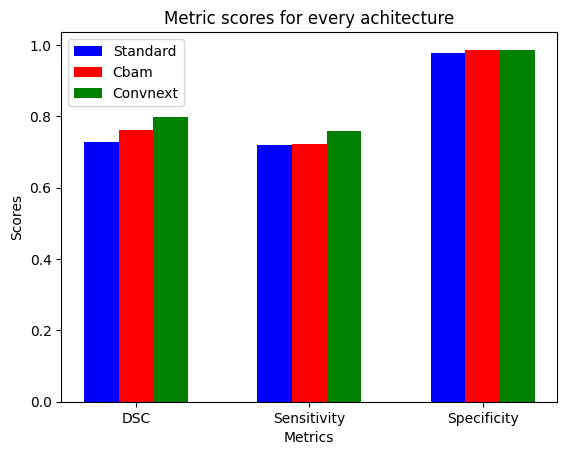

In [11]:
# Instantiate labels and score data
x = [0, 1, 2]
metrics = ["DSC", "Sensitivity", "Specificity"]
architectures = ["Standard", "CBAM", "ConvNeXt"]
standard_scores = [
    mean_dice_standard,
    mean_sens_standard,
    mean_spec_standard
]
cbam_scores = [
    mean_dice_cbam,
    mean_sens_cbam,
    mean_spec_cbam
]
conenxt_scores = [
    mean_dice_convnext,
    mean_sens_convnext,
    mean_spec_convnext
]

# ---- Plotting metric scores bar plots ----

# Place subplot
ax = plt.subplot(111)

# Set title and labels and plot the bar plots
ax.set_title("Metric scores for every achitecture")
ax.set_xticks(x, labels=metrics)
ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.bar([value-0.2 for value in x], standard_scores, width=0.2, color='b', align='center', label="Standard")
ax.bar([value for value in x], cbam_scores, width=0.2, color='r', align='center', label="Cbam")
ax.bar([value+0.2 for value in x], conenxt_scores, width=0.2, color="g", align="center", label="Convnext")

# Add a legend
ax.legend()

# Save the plot
plt.savefig("Images/metric_bars_isic.png")

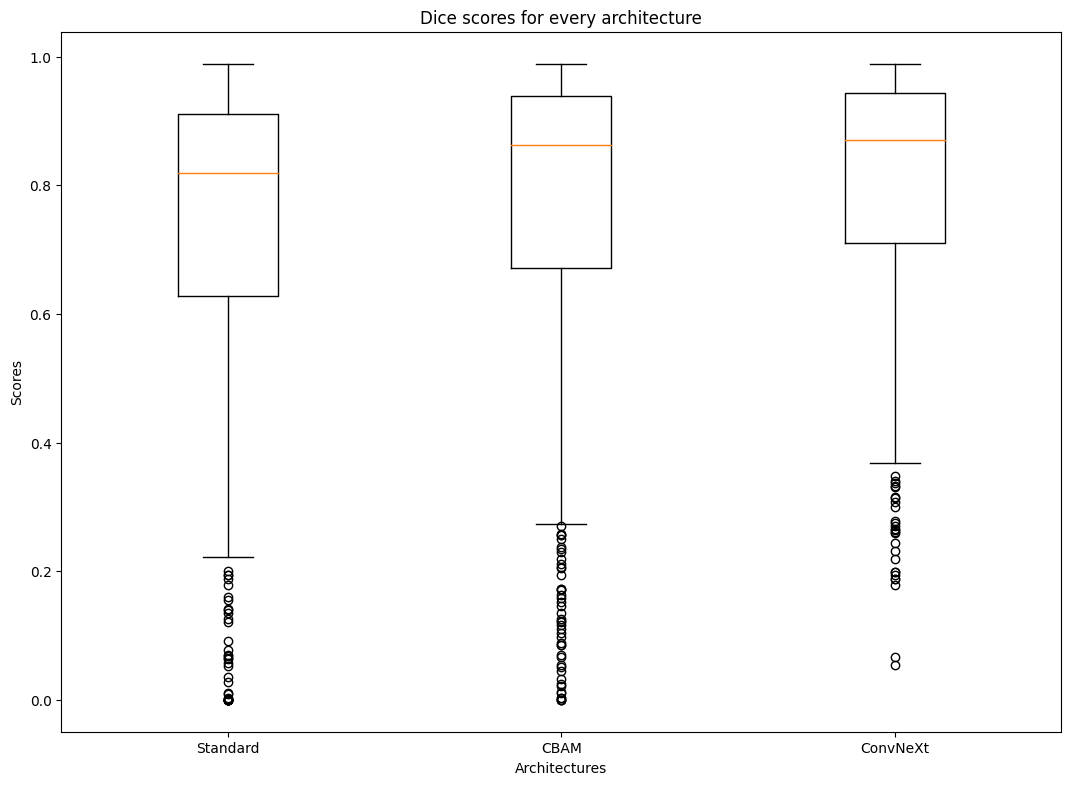

In [12]:
# Instantiate score data
values_dice = [dice_scores_standard, dice_scores_cbam, dice_scores_convnext]
values_sens = [sens_scores_standard, sens_scores_cbam, sens_scores_convnext]
values_spec = [spec_scores_standard, spec_scores_cbam, spec_scores_convnext]

# ---- Plotting dice scores ----

# Place figure and add axes
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([0, 0, 1, 1])

# Set title and labels and add the box plot
ax.set_title("Dice scores for every architecture")
ax.set_xlabel("Architectures")
ax.set_ylabel("Scores")
ax.boxplot(values_dice)
ax.set_xticks([1, 2, 3], labels=architectures)

# Save the plot
plt.savefig("Images/dice_scores_isic.png")

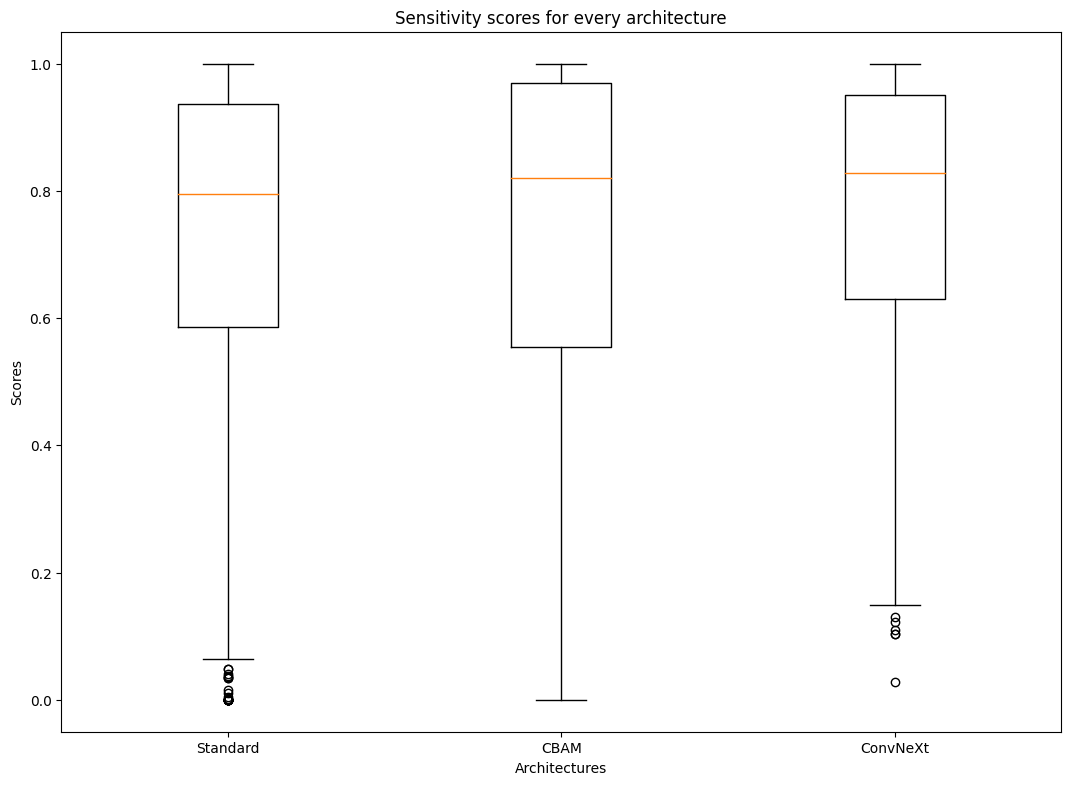

In [13]:
# ---- Plotting Sensitivity ----

# Place figure and add axes
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([0, 0, 1, 1])

# Set title and labels and add the box plot
ax.set_title("Sensitivity scores for every architecture")
ax.set_xlabel("Architectures")
ax.set_ylabel("Scores")
ax.boxplot(values_sens)
ax.set_xticks([1, 2, 3], labels=architectures)

# Save the plot
plt.savefig("Images/sensitivity_isic.png")

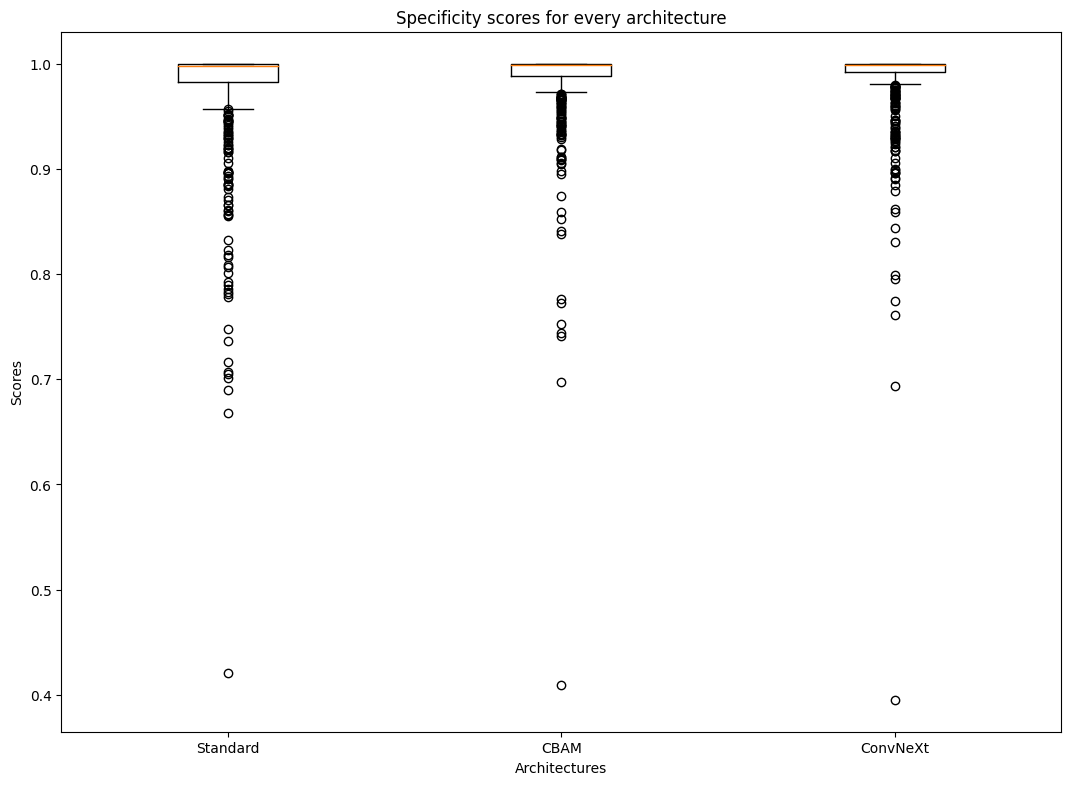

In [14]:
# ---- Plotting Specificity ----

# Place figure and add axes
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([0, 0, 1, 1])

# Set title and labels and add the box plot
ax.set_title("Specificity scores for every architecture")
ax.set_xlabel("Architectures")
ax.set_ylabel("Scores")
ax.boxplot(values_spec)
ax.set_xticks([1, 2, 3], labels=architectures)

# Save the image
plt.savefig("Images/specificity_isic.png")

This concludes the presentation of the results of training the CBAM U-Net and ConvNeXt U-Net architectures on the ISIC2018 dataset.


















































